In [151]:
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write, read
from scipy.signal import csd, chirp
import numpy as np
import matplotlib.pyplot as plt
import binascii

from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

264600 132300


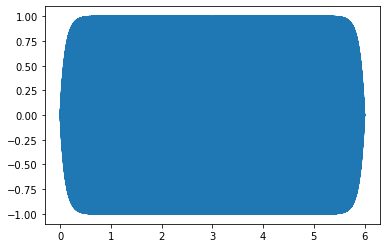

In [32]:
fs = 44100
sec = 3

k = 10
fl = 60
fu = 22000

t = np.linspace(0, sec, fs*sec)
chirp_signal = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic

inverse = np.flip(chirp_signal) # time reversed signal

combined = np.concatenate((inverse, chirp_signal), axis=None) # combine inverse chirp + chirp
t2 = np.linspace(0, 2*sec, fs*2*sec)
combined *= (1-np.exp(-k*t2))*(1-np.exp(-k*(2*sec-t2))) # apply exponential smoothing at ends
chirp_signal *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) # same, but for single chirp

print(len(combined), len(chirp_signal))
# plt.plot(t, chirp_signal)
plt.plot(t2, combined) # check profile

In [ ]:
seconds = 8
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
write('chirp_rec.wav', fs, recording)
plt.plot(recording)

Done


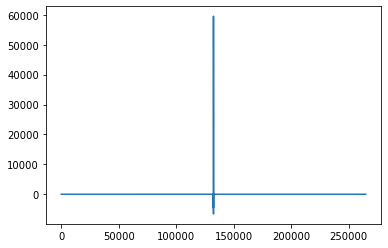

In [33]:
inverse_comb = np.flip(combined)
#conv = np.convolve(combined, inverse_comb) # real: recording[:, 0], ideal use: combined
conv = np.convolve(chirp_signal, inverse)
print("Done") # can take a while if long periods of time
plt.plot(conv)

In [34]:
max_index = np.argmax(conv) # find peak of signal for synchronisation, should be out by 1 sample
print("Index of peak: ", max_index)
trimmed = conv[max_index-1000:max_index+3000] # trim around the peak
trimmed /= np.linalg.norm(trimmed) # normalise

Index of peak:  132299


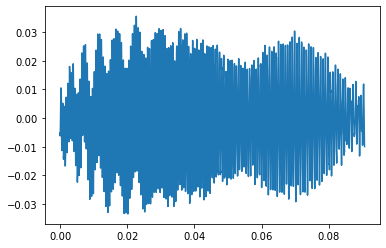

In [25]:
plt.plot(np.linspace(0, len(trimmed)/fs, len(trimmed)), trimmed)

1024


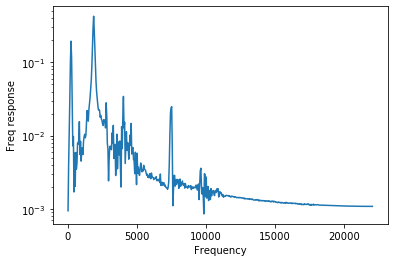

In [26]:
N = 1024
conv_fft = np.fft.fft(trimmed, N) # freq response is ft of impulse response
normalised = conv_fft / np.linalg.norm(conv_fft) # normalise
print(len(normalised))
plt.semilogy(np.linspace(0,fs/2,int(N/2)),np.abs(normalised)[0:int(N/2)]) # only care up to 22kHz
plt.ylabel("Freq response")
plt.xlabel("Frequency")
plt.show()

# Log sweep

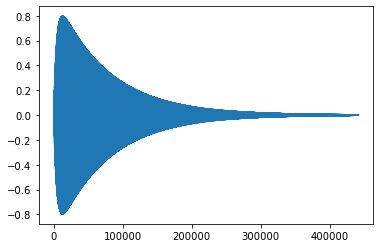

In [258]:
# form of log sweep
sec = 5
t = np.linspace(0, sec, fs*sec)
t2 = np.linspace(0, 2*sec, fs*2*sec)
x_t = np.sin(2 * np.pi * fl * sec * (np.exp( t * (np.log(fu / fl) / sec)) -1) /np.log(fu / fl) )
x_t_comb = np.concatenate((np.flip(x_t), x_t), axis=None)

x_t *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
x_t_comb *= (1-np.exp(-k*t2))*(1-np.exp(-k*(2*sec-t2)))

mod = np.exp(-t * np.log(fu / fl) / sec)
mod2 = np.exp(-t2 * np.log(fu / fl) / (sec*2)) # combined signal is 2x as long
rev_x_t = np.flip(x_t) * mod
rev_x_t_comb = np.flip(x_t_comb) * mod2

plt.plot(rev_x_t_comb)

In [259]:
sf.write('chirp_log_comb5.wav', x_t_comb, fs) # chirp_signal or combined
sd.play(x_t_comb, fs) # play signal
status = sd.wait()

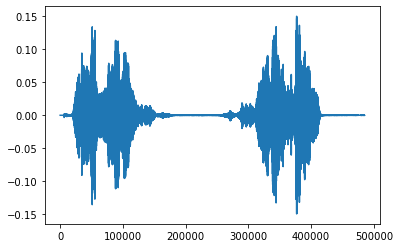

In [282]:
seconds = 11
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

sf.write('chirp_rec.wav', recording, fs)  # Save as WAV file 
plt.plot(recording)

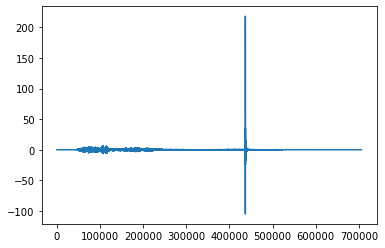

In [283]:
log_conv = np.convolve(rev_x_t, recording[:, 0])
plt.plot(log_conv)

445745


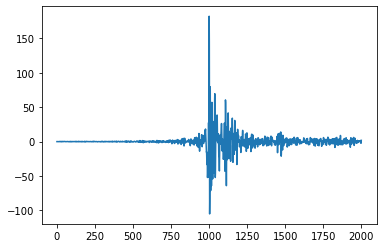

In [278]:
x_t_max = np.argmax(log_conv)
print(x_t_max)
plt.plot(log_conv[x_t_max-1000:x_t_max+1000])

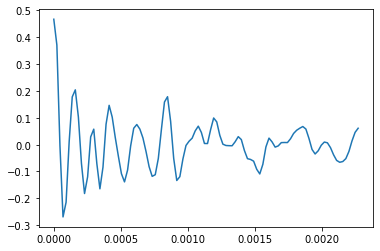

In [279]:
L = 100 # length of cyclic prefix
N = 1024

x_t_imp = log_conv[x_t_max:x_t_max+L]
x_t_imp /= np.linalg.norm(x_t_imp)

plt.plot(np.linspace(0, L/fs, L), x_t_imp)


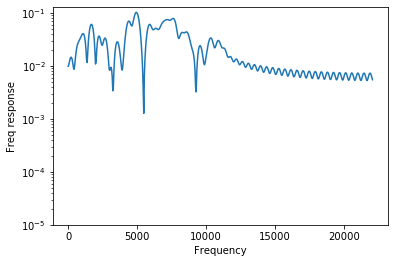

In [281]:
x_t_fft = np.fft.fft(x_t_imp, N) # freq response is ft of impulse response
x_t_fft /= np.linalg.norm(x_t_fft)
plt.semilogy(np.linspace(0,fs/2,int(N/2)),np.abs(x_t_fft)[0:int(N/2)]) # only care up to 22kHz
plt.ylabel("Freq response")
plt.xlabel("Frequency")
plt.ylim(10e-6)
plt.show()

# Synchronisation tests

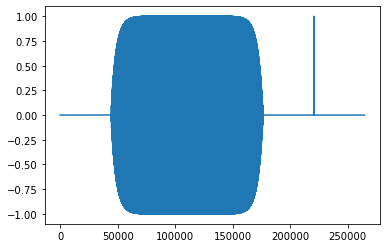

In [159]:
tst_op = np.concatenate((np.zeros(1*fs), chirp_signal, np.zeros(1*fs), np.ones(20), np.zeros(1*fs)), axis=None)
plt.plot(tst_op)

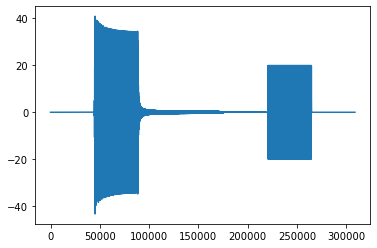

In [161]:
tst_conv = np.convolve(tst_op, inverse)
plt.plot(tst_conv)

45070
63756


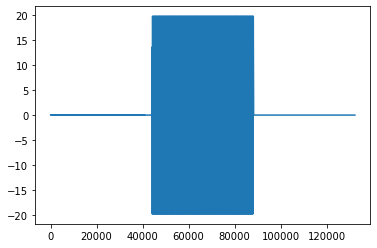

In [176]:
tst_max = np.argmax(tst_conv)
print(tst_max)
imp_only = tst_conv[4*fs:]
plt.plot(imp_only)
tst_imp = np.argmax(tst_conv[4*fs:])
print(tst_imp)

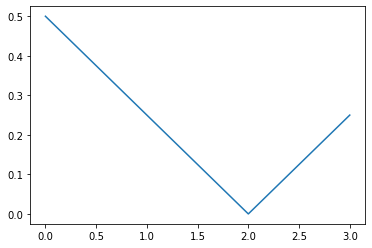

In [157]:
sim_channel = np.array([0.5, 0.25, 0.0, 0.25])
plt.plot(sim_channel)

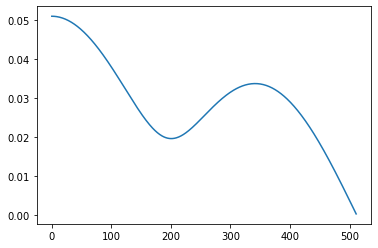

In [158]:
chan_fft = np.fft.fft(sim_channel, 1024)
chan_fft /= np.linalg.norm(chan_fft)
plt.plot(np.linspace(0,fs/2,int(N/2)),np.abs(chan_fft)[0:int(N/2)])

ValueError: Unknown format code 'b' for object of type 'float'

0.0022565205278905214


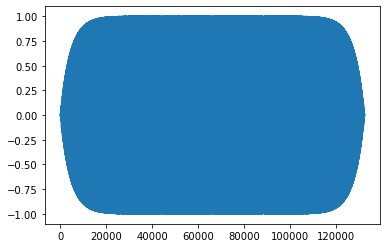

In [147]:
delay = 0.0 # seconds
#signal = np.fft.ifft(chirp_signal, 1024)
#signal = np.concatenate((signal[-10:], signal), axis=None)

channel_ip = np.concatenate((np.zeros(int(delay*fs)), chirp_signal), axis=None)
print(channel_ip[10])
plt.plot(channel_ip)

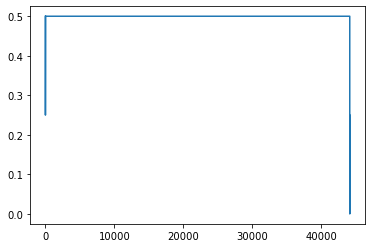

In [139]:
channel_op = np.convolve(sim_channel, channel_ip)
plt.plot(channel_op)

In [127]:
inverse = np.flip(channel_ip)
matched_op = np.convolve(channel_op, inverse)

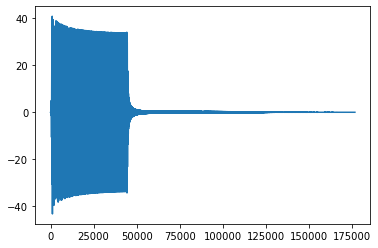

In [132]:
plt.plot(matched_op)

971


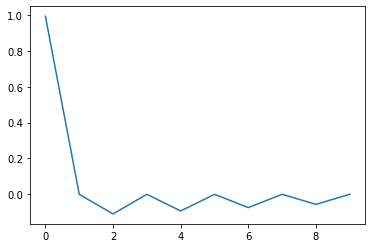

In [131]:
peak = np.argmax(matched_op)
print(peak)
ideal_impulse = conv[max_index:max_index+10] # trim around the peak
#ideal_impulse /= np.linalg.norm(ideal_impulse) # normalise
plt.plot(ideal_impulse)

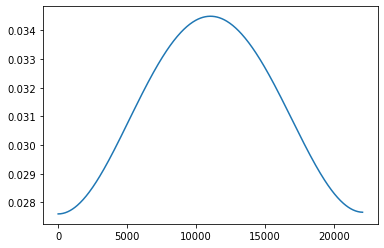

In [124]:
est_chan_fft = np.fft.fft(ideal_impulse, 1024)
est_chan_fft /= np.linalg.norm(est_chan_fft)
plt.plot(np.linspace(0,fs/2,int(N/2)),np.abs(est_chan_fft)[0:int(N/2)])